Do pairwise mutual information of ripple firing rates between cross region pairs

$I(X,Y)=-\sum_{x_i,y_i} p(x_i,y_i)log_2 \frac{p(x_i,y_i)}{p(x_i)p(y_i)}$


In [1]:
%reload_ext autoreload
%autoreload 2
from ripple_heterogeneity.utils import (
    functions,
    loading,
    batch_analysis,
)
from ripple_heterogeneity.readout import downstream_information
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nelpy as nel
from matplotlib.ticker import AutoMinorLocator
import os
from statannotations.Annotator import Annotator

functions.set_plotting_defaults()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\figures\panels'

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [161]:
# import os
# import glob

# files = glob.glob(r"Z:\Data\FujisawaS\GG\GG0406\*")
# files_new = [file.replace("GG.149","GG0406") for file in files]
# # files[0]
# files_new
# for files,file_new in zip(files,files_new):
#     os.rename(files, file_new)

In [168]:
df = pd.read_csv(r"Z:\home\ryanh\projects\ripple_heterogeneity\sessions.csv", index_col=0)
df.sort_values(by="basepath", inplace=True)
df = df.reset_index(drop=True)
df.to_csv(r"Z:\home\ryanh\projects\ripple_heterogeneity\sessions.csv")

## locate sessions with pfc or mec

In [2]:
df = pd.read_csv(r"Z:\home\ryanh\projects\ripple_heterogeneity\sessions.csv")

region_df = pd.DataFrame()
for basepath in df.basepath:
    brainRegions = loading.load_brain_regions(basepath)
    temp_df = pd.DataFrame()
    temp_df["brainRegions"] = brainRegions.keys()
    temp_df["basepath"] = basepath
    region_df = pd.concat([region_df, temp_df], ignore_index=True)

sessions = region_df[region_df.brainRegions.str.contains("PFC|EC1|EC2|EC3|EC4|EC5|MEC")]
df_sessions = pd.DataFrame()
df_sessions["basepath"] = sessions.basepath.unique()
df_sessions

,basepath
0,Z:\Data\AYAold\AYA7\day19
1,Z:\Data\AYAold\AYA7\day20
2,Z:\Data\AYAold\AYA7\day24
3,Z:\Data\AYAold\AYA7\day25
4,Z:\Data\AYAold\AYA7\day27
...,...
105,Z:\Data\FujisawaS\EE\EE0705fm
106,Z:\Data\FujisawaS\EE\EE0706fm
107,Z:\Data\FujisawaS\EE\EE0708fm
108,Z:\Data\HMC1\day12


## Main analysis

In [41]:
save_path = (
    r"Z:\home\ryanh\projects\ripple_heterogeneity\downstream_info_v3_w_state_score"
    )

batch_analysis.run(
    sessions,
    save_path,
    downstream_information.run,
    parallel=True,
    overwrite=False,
    verbose=True,
    skip_if_error=False,
    n_shuffles=None
)
# load results
results = downstream_information.load_results(save_path)

100%|██████████| 110/110 [00:00<00:00, 3243.99it/s]


In [42]:
results

,mutual_info,label,reference_id,target_id,reference,target,reference_uid,target_uid,environment,epoch,basepath
0,0.001765,deep_mec,0,16,CA1,MEC,59,87,sleep,pre,Z:\Data\AYAold\AYA7\day19
1,0.014432,deep_mec,0,17,CA1,MEC,59,89,sleep,pre,Z:\Data\AYAold\AYA7\day19
2,0.000109,deep_mec,0,18,CA1,MEC,59,90,sleep,pre,Z:\Data\AYAold\AYA7\day19
3,0.017407,deep_mec,0,19,CA1,MEC,59,91,sleep,pre,Z:\Data\AYAold\AYA7\day19
4,0.002549,deep_mec,0,20,CA1,MEC,59,92,sleep,pre,Z:\Data\AYAold\AYA7\day19
...,...,...,...,...,...,...,...,...,...,...,...
269280,0.075661,sup_pfc,13,28,PFC,CA1sp,20,44,sleep,post,Z:\Data\ORproject\OR18\day2
269281,0.061744,sup_pfc,13,31,PFC,CA1sr,20,47,sleep,post,Z:\Data\ORproject\OR18\day2
269282,0.056697,sup_pfc,14,27,PFC,CA1sp,21,41,sleep,post,Z:\Data\ORproject\OR18\day2
269283,0.025316,sup_pfc,14,28,PFC,CA1sp,21,44,sleep,post,Z:\Data\ORproject\OR18\day2


## check pre to post changes in mutual information

In [5]:
results["pair_id"] = results.reference_id.astype(str) + "_" + results.target_id.astype(str)

# results_pivot = results[results.mutual_info.notna()].pivot(index=["pair_id","basepath","label"], columns="epoch", values=["mutual_info","pval"]).reset_index()
results_pivot = results[results.mutual_info.notna()].pivot(index=["pair_id","basepath","label"], columns="epoch", values=["mutual_info"]).reset_index()

# results_pivot["pval_pre_post"] = (results_pivot.pval.post < 0.05) & (results_pivot.pval.post < 0.05)

results_pivot["pre_post_ratio"] = (results_pivot["mutual_info"].post - results_pivot["mutual_info"].pre) / (results_pivot["mutual_info"].post + results_pivot["mutual_info"].pre)

results_pivot.head()

pair_id                     basepath     label mutual_info            \
epoch                                                       post       pre   
0         0_1  Z:\Data\Kenji\ec013.868_893  deep_mec    0.056018  0.035635   
1        0_10  Z:\Data\Kenji\ec013.393_418   sup_mec    0.000974  0.022380   
2        0_10  Z:\Data\Kenji\ec013.451_470  deep_mec    0.055622  0.037425   
3        0_10  Z:\Data\Kenji\ec013.608_632  deep_mec    0.140702  0.143820   
4        0_10  Z:\Data\Kenji\ec013.656_674   sup_mec    0.054160  0.015719   

                pre_post_ratio  
epoch      task                 
0      0.048914       0.222396  
1      0.003380      -0.916595  
2      0.105231       0.195568  
3      0.363133      -0.010960  
4      0.000000       0.550110

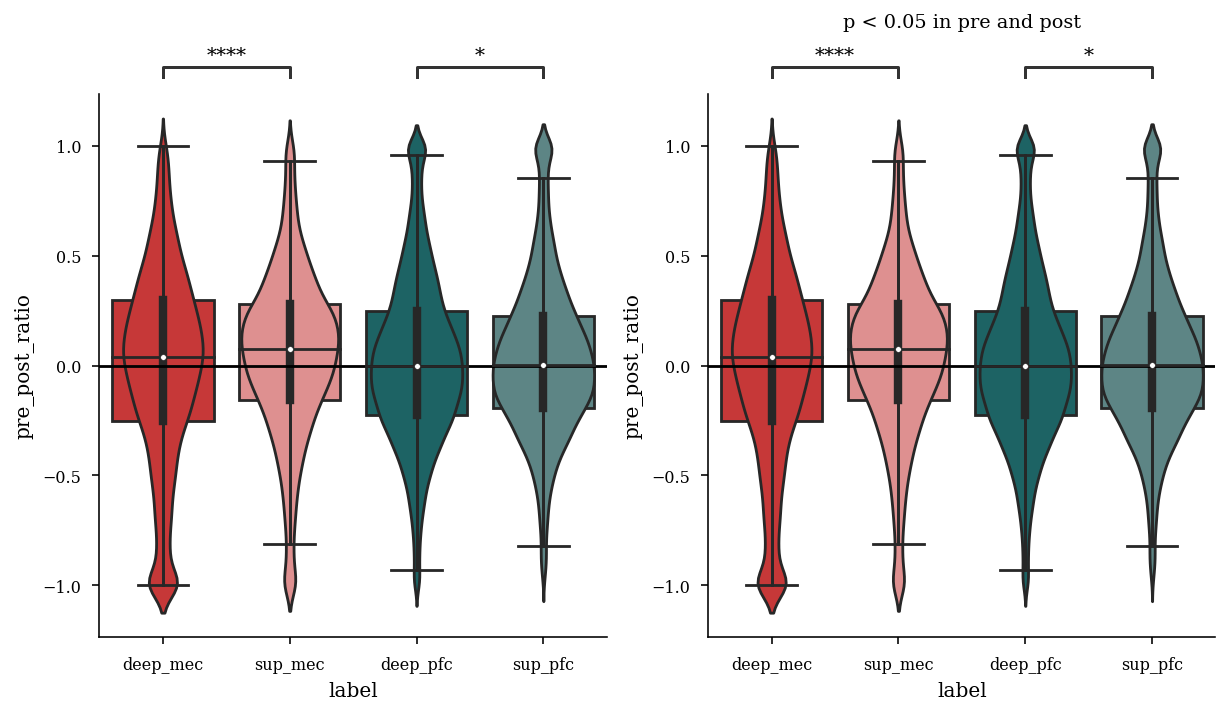

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

group_colors = {
    "deep_mec": "#de2020",
    "sup_mec": "#eb8383",
    "deep_pfc": "#116f70",
    "sup_pfc": "#568c8c",
}
sns.set_palette(sns.color_palette(group_colors.values()))

sns.violinplot(
    x="label", y="pre_post_ratio", data=results_pivot, showfliers=False, ax=ax[0]
)
sns.boxplot(
    x="label", y="pre_post_ratio", data=results_pivot, showfliers=False, ax=ax[0]
)
ax[0].axhline(0, color="black")

box_pairs = [
    ("sup_mec", "deep_mec"),
    ("sup_pfc", "deep_pfc"),
]
annotator = Annotator(
    ax[0],
    box_pairs,
    data=results_pivot,
    x="label",
    y="pre_post_ratio",
)
annotator.configure(
    test="t-test_ind",
    text_format="star",
    loc="outside",
    comparisons_correction=None,
    verbose=0,
)
annotator.apply_and_annotate()

sns.violinplot(
    x="label",
    y="pre_post_ratio",
    data=results_pivot,
    showfliers=False,
    ax=ax[1],
)
sns.boxplot(
    x="label",
    y="pre_post_ratio",
    data=results_pivot,
    showfliers=False,
    ax=ax[1],
)
ax[1].set_title("p < 0.05 in pre and post",y=1.1)
ax[1].axhline(0, color="black")

box_pairs = [
    ("sup_mec", "deep_mec"),
    ("sup_pfc", "deep_pfc"),
]
annotator = Annotator(
    ax[1],
    box_pairs,
    data=results_pivot,
    x="label",
    y="pre_post_ratio",
)
annotator.configure(
    test="t-test_ind",
    text_format="star",
    loc="outside",
    comparisons_correction=None,
    verbose=0,
)
annotator.apply_and_annotate()

sns.despine()
plt.show()


In [7]:
results.describe()

,mutual_info,reference_id,target_id,reference_uid,target_uid
count,269285.000000,269285.000000,269285.000000,269285.000000,269285.000000
mean,0.101231,73.971506,165.578844,126.474334,288.017665
std,0.146717,60.735539,67.951160,106.166955,112.810484
min,0.000000,0.000000,1.000000,1.000000,7.000000
25%,0.019593,23.000000,116.000000,44.000000,223.000000
50%,0.057980,59.000000,174.000000,101.000000,276.000000
75%,0.123564,114.000000,211.000000,175.000000,337.000000
max,2.429052,255.000000,318.000000,588.000000,743.000000


## pre task post mutual information

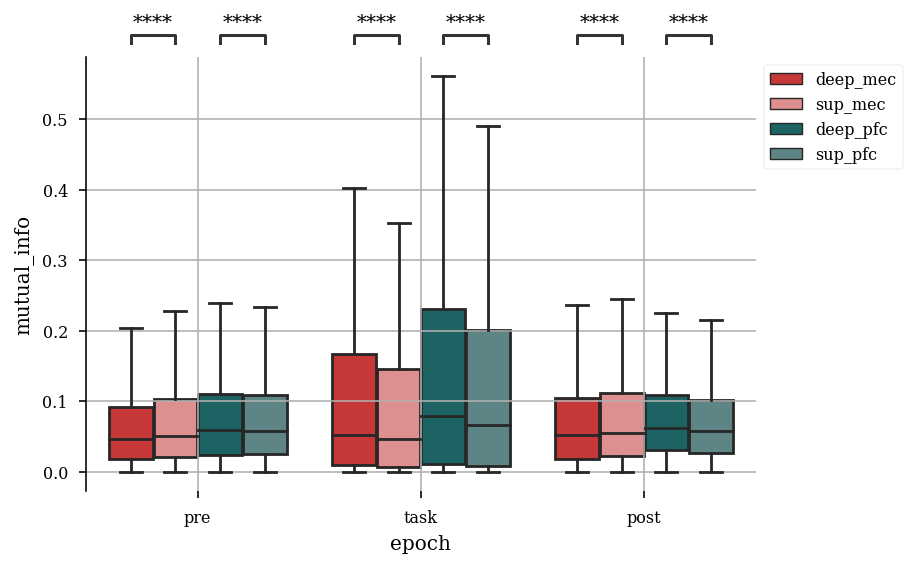

In [8]:
group_colors = {
    "deep_mec": "#de2020",
    "sup_mec": "#eb8383",
    "deep_pfc": "#116f70",
    "sup_pfc": "#568c8c",
}
sns.set_palette(sns.color_palette(group_colors.values()))

sns.boxplot(
    x="epoch",
    hue="label",
    y="mutual_info",
    hue_order=group_colors.keys(),
    data=results,
    showfliers=False,
)
# sns.stripplot(
#     x="epoch",
#     hue="label",
#     y="mutual_info",
#     hue_order=group_colors.keys(),
#     data=results,
#     dodge=True,
#     size=2,
# )

# plt.yscale("log")

plt.grid()
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
sns.despine(bottom=True)
# plt.gca().yaxis.set_minor_locator(AutoMinorLocator())

box_pairs = [
    (("pre", "deep_mec"), ("pre", "sup_mec")),
    (("pre", "deep_pfc"), ("pre", "sup_pfc")),
    (("task", "deep_mec"), ("task", "sup_mec")),
    (("task", "deep_pfc"), ("task", "sup_pfc")),
    (("post", "deep_mec"), ("post", "sup_mec")),
    (("post", "deep_pfc"), ("post", "sup_pfc")),
]
annotator = Annotator(
    plt.gca(),
    box_pairs,
    data=results,
    x="epoch",
    y="mutual_info",
    hue="label",
    hue_order=group_colors.keys(),
)
annotator.configure(
    test="t-test_ind",
    text_format="star",
    loc="outside",
    comparisons_correction=None,
    verbose=0,
)
annotator.apply_and_annotate()
plt.show()


## just post task mutual information (main figure)

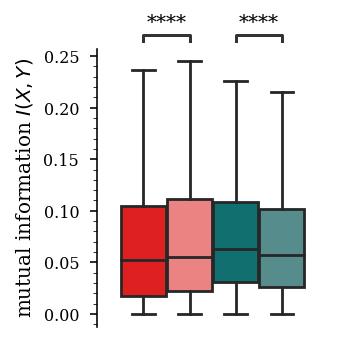

In [9]:
fig = plt.figure(
    figsize=functions.set_size("thesis", fraction=.35, subplots=(2, 1)), edgecolor=None
)
sns.boxplot(
    x="epoch",
    hue="label",
    y="mutual_info",
    hue_order=group_colors.keys(),
    data=results[(results.epoch == "post")],
    showfliers=False,
    saturation=1
)
plt.legend("",frameon=False)
sns.despine(bottom=True)
plt.gca().get_xaxis().set_visible(False)
ax = plt.gca()
ax.yaxis.set_minor_locator(AutoMinorLocator())
plt.ylabel("mutual information $I(X,Y)$")

box_pairs = [
    (("post", "deep_mec"), ("post", "sup_mec")),
    (("post", "deep_pfc"), ("post", "sup_pfc")),
]
annotator = Annotator(
    plt.gca(),
    box_pairs,
    data=results[(results.epoch == "post")],
    x="epoch",
    y="mutual_info",
    hue="label",
    hue_order=group_colors.keys(),
)
annotator.configure(
    test="Mann-Whitney",
    text_format="star",
    loc="outside",
    comparisons_correction=None,
    verbose=0,
)
annotator.apply_and_annotate()

plt.savefig(
    os.path.join(fig_save_path, "deep_sup_mec_pfc_mutual_info.svg"),
    dpi=300,
    bbox_inches="tight",
)
plt.show()

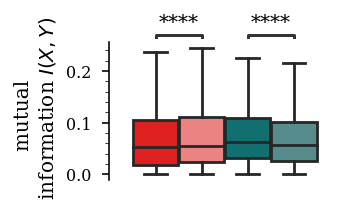

In [10]:
fig = plt.figure(
    figsize=functions.set_size("thesis", fraction=.35, subplots=(1, 1)), edgecolor=None
)
sns.boxplot(
    x="epoch",
    hue="label",
    y="mutual_info",
    hue_order=group_colors.keys(),
    data=results[(results.epoch == "post")],
    showfliers=False,
    saturation=1
)
plt.legend("",frameon=False)
sns.despine(bottom=True)
plt.gca().get_xaxis().set_visible(False)
ax = plt.gca()
ax.yaxis.set_minor_locator(AutoMinorLocator())
plt.ylabel("mutual \n information $I(X,Y)$")
# plt.yscale("log")
box_pairs = [
    (("post", "deep_mec"), ("post", "sup_mec")),
    (("post", "deep_pfc"), ("post", "sup_pfc")),
]
annotator = Annotator(
    plt.gca(),
    box_pairs,
    data=results[(results.epoch == "post")],
    x="epoch",
    y="mutual_info",
    hue="label",
    hue_order=group_colors.keys(),
)
annotator.configure(
    test="Mann-Whitney",
    text_format="star",
    loc="outside",
    comparisons_correction=None,
    verbose=0,
)
annotator.apply_and_annotate()

plt.savefig(
    os.path.join(fig_save_path, "deep_sup_mec_pfc_mutual_info.svg"),
    dpi=300,
    bbox_inches="tight",
)
plt.show()

## for each cortical cell, what proportion of its highest MI ca1 partner was deep or superficial?

In [18]:
results.groupby(["label","basepath"]).apply(lambda x: x.iloc[np.argmax(x.mutual_info)].label)

label     basepath                   
deep_mec  Z:\Data\AYAold\AYA7\day19      deep_mec
          Z:\Data\AYAold\AYA7\day20      deep_mec
          Z:\Data\AYAold\AYA7\day24      deep_mec
          Z:\Data\AYAold\AYA9\day12      deep_mec
          Z:\Data\AYAold\AYA9\day14      deep_mec
                                           ...   
sup_pfc   Z:\Data\HMC1\day13              sup_pfc
          Z:\Data\HMC1\day8               sup_pfc
          Z:\Data\HMC1\day9               sup_pfc
          Z:\Data\ORproject\OR18\day1     sup_pfc
          Z:\Data\ORproject\OR18\day2     sup_pfc
Length: 117, dtype: object

In [48]:
# put cortex always as target
idx = results.target.str.contains("CA1")
results.loc[idx, "target"] = results.loc[idx, "reference"]
results.loc[idx, "reference"] = "CA1"

target_id = results.loc[idx, "target_id"] 
results.loc[idx, "target_id"] = results.loc[idx, "reference_id"]
results.loc[idx, "reference_id"] = target_id

target_uid = results.loc[idx, "target_uid"] 
results.loc[idx, "target_uid"] = results.loc[idx, "reference_uid"]
results.loc[idx, "reference_uid"] = target_uid

results["pair_id"] = results.reference_id.astype(str) + "_" + results.target_id.astype(str)

results.loc[results.reference.str.contains("CA1"),"reference"] = "CA1"
results.loc[results.target.str.contains('EC5|EC4|EC2|EC3|EC1'),"target"] = "MEC"

results

,mutual_info,label,reference_id,target_id,reference,target,reference_uid,target_uid,environment,epoch,basepath,pair_id
0,0.001765,deep_mec,0,16,CA1,MEC,59,87,sleep,pre,Z:\Data\AYAold\AYA7\day19,0_16
1,0.014432,deep_mec,0,17,CA1,MEC,59,89,sleep,pre,Z:\Data\AYAold\AYA7\day19,0_17
2,0.000109,deep_mec,0,18,CA1,MEC,59,90,sleep,pre,Z:\Data\AYAold\AYA7\day19,0_18
3,0.017407,deep_mec,0,19,CA1,MEC,59,91,sleep,pre,Z:\Data\AYAold\AYA7\day19,0_19
4,0.002549,deep_mec,0,20,CA1,MEC,59,92,sleep,pre,Z:\Data\AYAold\AYA7\day19,0_20
...,...,...,...,...,...,...,...,...,...,...,...,...
269280,0.075661,sup_pfc,28,13,CA1,PFC,44,20,sleep,post,Z:\Data\ORproject\OR18\day2,28_13
269281,0.061744,sup_pfc,31,13,CA1,PFC,47,20,sleep,post,Z:\Data\ORproject\OR18\day2,31_13
269282,0.056697,sup_pfc,27,14,CA1,PFC,41,21,sleep,post,Z:\Data\ORproject\OR18\day2,27_14
269283,0.025316,sup_pfc,28,14,CA1,PFC,44,21,sleep,post,Z:\Data\ORproject\OR18\day2,28_14


In [101]:
results_pivot = results.query("epoch=='post'").groupby(["basepath", "target_uid"]).apply(
    lambda x: pd.Series(
        {
            "target_area": x.target.unique()[0],
            "highest_mi_label": x.iloc[np.argmax(x.mutual_info)].label,
            "mi_deep_median": x.iloc[x.label.str.contains("deep").values].mutual_info.median(),
            "mi_sup_median": x.iloc[x.label.str.contains("sup").values].mutual_info.median(),
            "n_deep": x.iloc[x.label.str.contains("deep").values].reference_uid.nunique(),
            "n_sup": x.iloc[x.label.str.contains("sup").values].reference_uid.nunique()
        }
    )
).reset_index()
results_pivot

,basepath,target_uid,target_area,highest_mi_label,mi_deep_median,mi_sup_median,n_deep,n_sup
0,Z:\Data\AYAold\AYA7\day19,87,MEC,deep_mec,0.032980,0.030821,12,1
1,Z:\Data\AYAold\AYA7\day19,89,MEC,deep_mec,0.021411,0.011729,12,1
2,Z:\Data\AYAold\AYA7\day19,90,MEC,deep_mec,0.010310,0.000829,12,1
3,Z:\Data\AYAold\AYA7\day19,91,MEC,deep_mec,0.000685,0.000276,12,1
4,Z:\Data\AYAold\AYA7\day19,92,MEC,deep_mec,0.019176,0.012925,12,1
...,...,...,...,...,...,...,...,...
1733,Z:\Data\ORproject\OR18\day2,17,PFC,deep_pfc,0.107870,0.119373,14,3
1734,Z:\Data\ORproject\OR18\day2,18,PFC,deep_pfc,0.086761,0.068578,14,3
1735,Z:\Data\ORproject\OR18\day2,19,PFC,deep_pfc,0.066957,0.042789,14,3
1736,Z:\Data\ORproject\OR18\day2,20,PFC,deep_pfc,0.105907,0.075661,14,3


In [120]:
results_pivot.highest_mi_label.unique()

array(['deep_mec', 'sup_mec', 'sup_pfc', 'deep_pfc'], dtype=object)

In [121]:
results_pivot[results_pivot.highest_mi_label.str.contains("deep")]


,basepath,target_uid,target_area,highest_mi_label,mi_deep_median,mi_sup_median,n_deep,n_sup
0,Z:\Data\AYAold\AYA7\day19,87,MEC,deep_mec,0.032980,0.030821,12,1
1,Z:\Data\AYAold\AYA7\day19,89,MEC,deep_mec,0.021411,0.011729,12,1
2,Z:\Data\AYAold\AYA7\day19,90,MEC,deep_mec,0.010310,0.000829,12,1
3,Z:\Data\AYAold\AYA7\day19,91,MEC,deep_mec,0.000685,0.000276,12,1
4,Z:\Data\AYAold\AYA7\day19,92,MEC,deep_mec,0.019176,0.012925,12,1
...,...,...,...,...,...,...,...,...
1733,Z:\Data\ORproject\OR18\day2,17,PFC,deep_pfc,0.107870,0.119373,14,3
1734,Z:\Data\ORproject\OR18\day2,18,PFC,deep_pfc,0.086761,0.068578,14,3
1735,Z:\Data\ORproject\OR18\day2,19,PFC,deep_pfc,0.066957,0.042789,14,3
1736,Z:\Data\ORproject\OR18\day2,20,PFC,deep_pfc,0.105907,0.075661,14,3


In [139]:
results_pivot.query("n_deep > 5 & n_sup > 5").groupby(["target_area","highest_mi_label"]).count().reset_index()

,target_area,highest_mi_label,basepath,target_uid,mi_deep_median,mi_sup_median,n_deep,n_sup
0,MEC,deep_mec,538,538,538,538,538,538
1,MEC,sup_mec,47,47,47,47,47,47
2,PFC,deep_pfc,540,540,540,540,540,540
3,PFC,sup_pfc,256,256,256,256,256,256


In [125]:
print(results_pivot.query("target_area=='MEC'").highest_mi_label.str.contains("deep").sum() / results_pivot.query("target_area=='MEC'").shape[0])
print(results_pivot.query("target_area=='MEC'").highest_mi_label.str.contains("sup").sum() / results_pivot.query("target_area=='MEC'").shape[0])

print(results_pivot.query("target_area=='PFC'").highest_mi_label.str.contains("deep").sum() / results_pivot.query("target_area=='PFC'").shape[0])
print(results_pivot.query("target_area=='PFC'").highest_mi_label.str.contains("sup").sum() / results_pivot.query("target_area=='PFC'").shape[0])

0.8929016189290162
0.10709838107098381
0.7080213903743315
0.29197860962566846


In [142]:
results_pivot["deep_sup_ratio"] = results_pivot.mi_deep_median / results_pivot.mi_sup_median

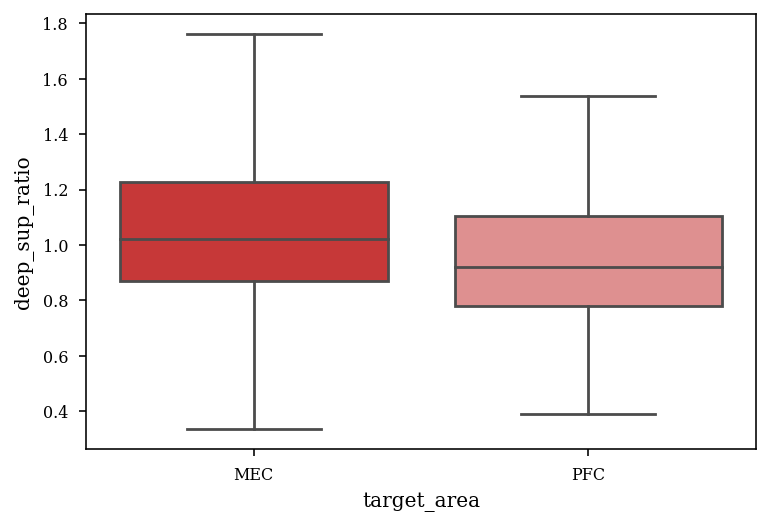

In [143]:
idx = (results_pivot.n_sup > 5) & (results_pivot.n_deep > 5)
sns.boxplot(data=results_pivot[idx],x="target_area",y="deep_sup_ratio",showfliers=False)
plt.show()

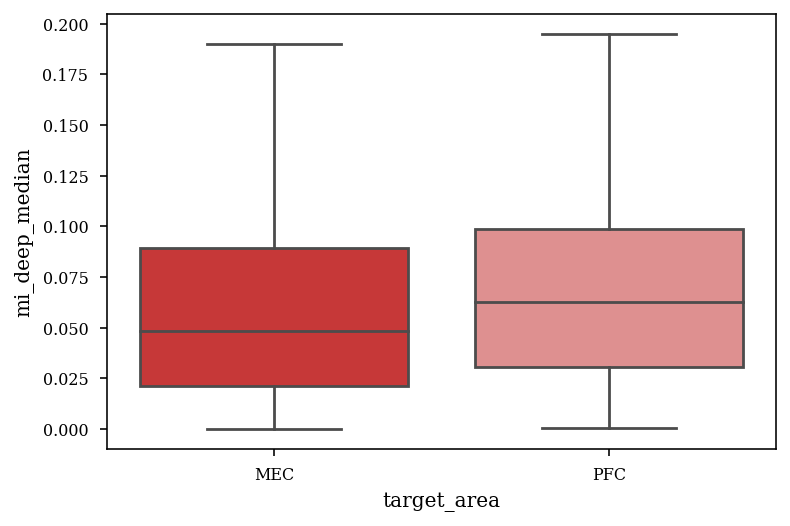

<AxesSubplot:xlabel='target_area', ylabel='mi_sup_median'>

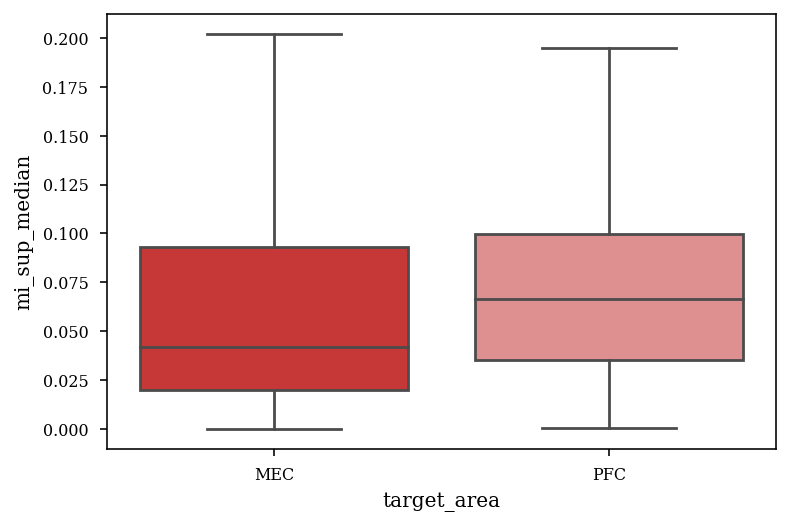

In [144]:
idx = (results_pivot.n_sup > 5) & (results_pivot.n_deep > 5)
sns.boxplot(data=results_pivot[idx],x="target_area",y="mi_deep_median",showfliers=False)
plt.show()
sns.boxplot(data=results_pivot[idx],x="target_area",y="mi_sup_median",showfliers=False)

In [50]:
basepath = "Z:\Data\AYAold\AYA7\day19"
label = "sup_mec"
results.query("basepath == @basepath and label == @label")

,mutual_info,label,reference_id,target_id,reference,target,reference_uid,target_uid,environment,epoch,basepath,pair_id
120,0.005393,sup_mec,10,16,CA1,MEC,75,87,sleep,pre,Z:\Data\AYAold\AYA7\day19,10_16
121,0.026219,sup_mec,10,17,CA1,MEC,75,89,sleep,pre,Z:\Data\AYAold\AYA7\day19,10_17
122,0.002409,sup_mec,10,18,CA1,MEC,75,90,sleep,pre,Z:\Data\AYAold\AYA7\day19,10_18
123,0.033844,sup_mec,10,19,CA1,MEC,75,91,sleep,pre,Z:\Data\AYAold\AYA7\day19,10_19
124,0.013382,sup_mec,10,20,CA1,MEC,75,92,sleep,pre,Z:\Data\AYAold\AYA7\day19,10_20
125,0.032998,sup_mec,10,21,CA1,MEC,75,93,sleep,pre,Z:\Data\AYAold\AYA7\day19,10_21
126,0.000000,sup_mec,10,22,CA1,MEC,75,94,sleep,pre,Z:\Data\AYAold\AYA7\day19,10_22
127,0.013170,sup_mec,10,23,CA1,MEC,75,95,sleep,pre,Z:\Data\AYAold\AYA7\day19,10_23
128,0.006187,sup_mec,10,24,CA1,MEC,75,96,sleep,pre,Z:\Data\AYAold\AYA7\day19,10_24
129,0.008581,sup_mec,10,25,CA1,MEC,75,97,sleep,pre,Z:\Data\AYAold\AYA7\day19,10_25


## check prop of significant pairs

In [ ]:
sig_mi_df = results.groupby(["epoch", "label"]).pval.apply(lambda x: (x < 0.05).sum() / len(x)).reset_index()
sig_mi_df.rename(columns={"pval": "proportion significant"}, inplace=True)
sig_mi_df

<AxesSubplot:xlabel='epoch', ylabel='proportion significant'>

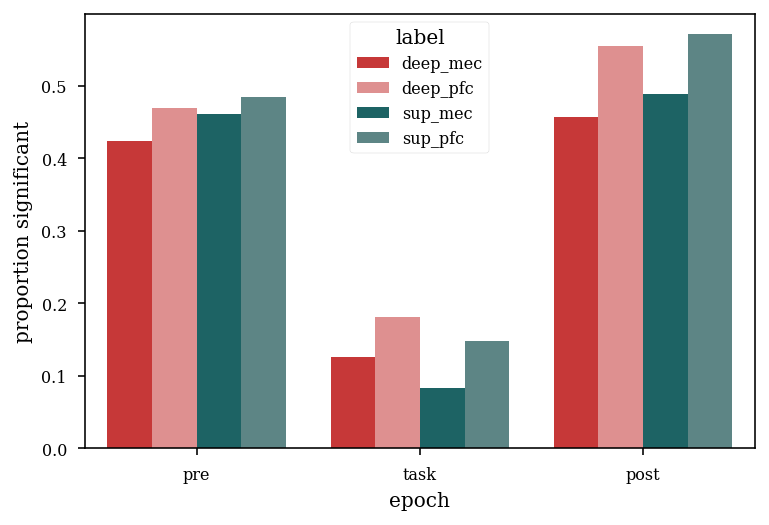

In [39]:
sns.barplot(x="epoch", y="proportion significant",hue="label",order=["pre","task","post"], data=sig_mi_df)

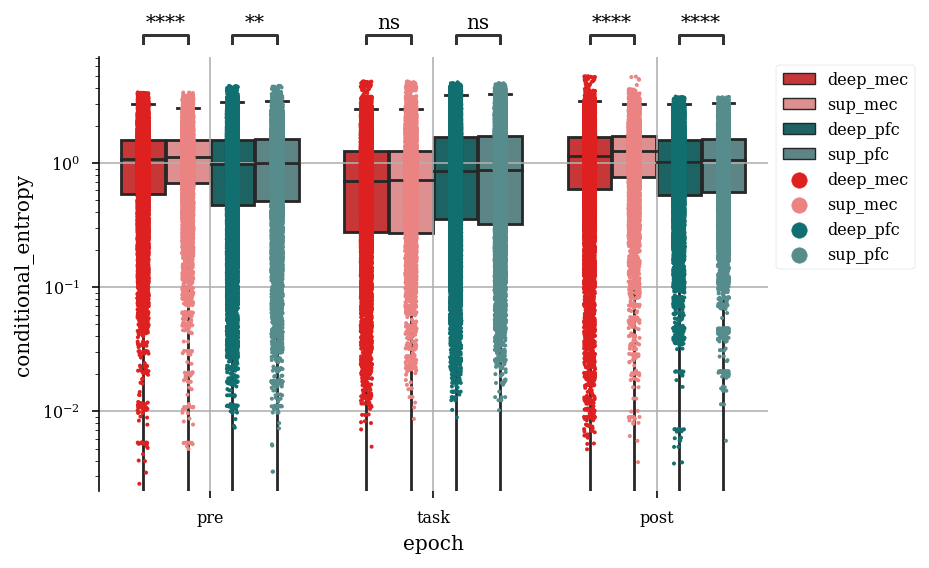

In [239]:
# sns.boxplot(
#     x="epoch",
#     hue="label",
#     y="conditional_entropy",
#     hue_order=group_colors.keys(),
#     data=results,
#     showfliers=False,
# )
# sns.stripplot(
#     x="epoch",
#     hue="label",
#     y="conditional_entropy",
#     hue_order=group_colors.keys(),
#     data=results,
#     dodge=True,
#     size=2,
# )

# plt.yscale("log")
# plt.grid()
# plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
# sns.despine(bottom=True)

# box_pairs = [
#     (("pre", "deep_mec"), ("pre", "sup_mec")),
#     (("pre", "deep_pfc"), ("pre", "sup_pfc")),
#     (("task", "deep_mec"), ("task", "sup_mec")),
#     (("task", "deep_pfc"), ("task", "sup_pfc")),
#     (("post", "deep_mec"), ("post", "sup_mec")),
#     (("post", "deep_pfc"), ("post", "sup_pfc")),
# ]
# annotator = Annotator(
#     plt.gca(),
#     box_pairs,
#     data=results,
#     x="epoch",
#     y="conditional_entropy",
#     hue="label",
#     hue_order=group_colors.keys(),
# )
# annotator.configure(
#     test="t-test_ind",
#     text_format="star",
#     loc="outside",
#     comparisons_correction=None,
#     verbose=0,
# )
# annotator.apply_and_annotate()
# plt.show()

In [33]:
# add animal id to results
results["animal_id"] = results.basepath.map(dict([(basepath, loading.get_animal_id(basepath)) for basepath in results.basepath.unique()]))
results.animal_id.unique()

array(['AYA7', 'AYA9', 'EE', 'HMC1', 'ec013', 'ec014', 'Kenji', 'ec016',
       'i01_m', 'OR18'], dtype=object)

In [34]:
results.to_csv(r"Z:\home\ryanh\projects\ripple_heterogeneity\downstream_information_results.csv")

# Testing below

In [8]:
from pyinform import conditional_entropy,entropy_rate,mutual_info,transfer_entropy

# xs = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1]
# ys = [0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,1]
# conditional_entropy(xs,ys) 

In [5]:
basepath = r"Z:\Data\HMC1\day13"
st,cm = loading.load_spikes(basepath,putativeCellType="Pyr",brainRegion="PFC|CA1|MEC")

In [6]:
ripples_df = loading.load_ripples_events(basepath)
ripples = nel.EpochArray(np.array([ripples_df.start,ripples_df.stop]).T).expand(0.05,direction="start").expand(0.2,direction="stop")
# ripples.expand(0.05,direction="start")

ripple_mat = functions.get_participation(st.data,ripples.starts,ripples.stops,par_type="firing_rate")
ripple_mat.shape

(319, 7471)

In [52]:
import itertools


def pairwise_info(X):
    """
    Compute the pairwise mutual information between all pairs of variables in X.
    inputs:
        X: a numpy array of shape (n,d) where d is the number of samples and n is the number of variables
    outputs:
        a numpy array of shape (n,n) where the (i,j) entry is the mutual information between the ith and jth variables

    """
    x = np.arange(0, X.shape[0])
    pairs = np.array(list(itertools.combinations(x, 2)))
    mi = []
    ce = []
    for pair in pairs:
        mi.append(mutual_info(X[pair[0], :], X[pair[1], :]))
        ce.append(conditional_entropy(X[pair[0], :], X[pair[1], :]))
    return np.hstack(mi),np.hstack(ce), pairs

def pairwise_conditional_entropy(X):
    """
    Compute the pairwise mutual information between all pairs of variables in X.
    inputs:
        X: a numpy array of shape (n,d) where d is the number of samples and n is the number of variables
    outputs:
        a numpy array of shape (n,n) where the (i,j) entry is the mutual information between the ith and jth variables

    """
    x = np.arange(0, X.shape[0])
    pairs = np.array(list(itertools.product(x,repeat=2)))
    ce = []
    for pair in pairs:
        ce.append(conditional_entropy(X[pair[0], :], X[pair[1], :]))
    return np.hstack(ce), pairs

mi, ce, pairs_mi= pairwise_info(ripple_mat)
ce, pairs_ce = pairwise_conditional_entropy(ripple_mat)


In [103]:
def find_pairs(cm,pairs,pair_1,pair_2,layer):
    pairs_idx = (
        np.in1d(pairs[:, 0], np.where(cm.brainRegion.str.contains(pair_1) & cm.deepSuperficial.str.contains(layer))[0])
        & np.in1d(pairs[:, 1], np.where(cm.brainRegion.str.contains(pair_2))[0])
    ) | (
        np.in1d(pairs[:, 0], np.where(cm.brainRegion.str.contains(pair_2))[0])
        & np.in1d(pairs[:, 1], np.where(cm.brainRegion.str.contains(pair_1) & cm.deepSuperficial.str.contains(layer))[0])
    )
    return pairs_idx
deep_pfc = find_pairs(cm,pairs_mi,"CA1","PFC","Deep")
deep_mec = find_pairs(cm,pairs_mi,"CA1","MEC","Deep")
sup_pfc = find_pairs(cm,pairs_mi,"CA1","PFC","Superficial")
sup_mec = find_pairs(cm,pairs_mi,"CA1","MEC","Superficial")

In [140]:


def make_df(ce,pairs,cm,y_label=None):
    deep_pfc = find_pairs(cm,pairs,"CA1","PFC","Deep")
    deep_mec = find_pairs(cm,pairs,"CA1","MEC","Deep")
    sup_pfc = find_pairs(cm,pairs,"CA1","PFC","Superficial")
    sup_mec = find_pairs(cm,pairs,"CA1","MEC","Superficial")

    df = pd.DataFrame()

    df[y_label] = np.hstack([ce[deep_pfc], ce[deep_mec], ce[sup_pfc], ce[sup_mec]])
    df["label"] = np.hstack(
        [
            ["deep_pfc"] * len(ce[deep_pfc]),
            ["deep_mec"] * len(ce[deep_mec]),
            ["sup_pfc"] * len(ce[sup_pfc]),
            ["sup_mec"] * len(ce[sup_mec]),
        ]
    )
    df["reference_id"] = np.hstack(
        [
            pairs[deep_pfc, 0],
            pairs[deep_mec, 0],
            pairs[sup_pfc, 0],
            pairs[sup_mec, 0],
        ]
    )

    df["target_id"] = np.hstack(
        [
            pairs[deep_pfc, 1],
            pairs[deep_mec, 1],
            pairs[sup_pfc, 1],
            pairs[sup_mec, 1],
        ]
    )

    df["reference"] = np.hstack(
        [
            cm.brainRegion.iloc[pairs[deep_pfc, 0]],
            cm.brainRegion.iloc[pairs[deep_mec, 0]],
            cm.brainRegion.iloc[pairs[sup_pfc, 0]],
            cm.brainRegion.iloc[pairs[sup_mec, 0]],
        ]
    )

    df["target"] = np.hstack(
        [
            cm.brainRegion.iloc[pairs[deep_pfc, 1]],
            cm.brainRegion.iloc[pairs[deep_mec, 1]],
            cm.brainRegion.iloc[pairs[sup_pfc, 1]],
            cm.brainRegion.iloc[pairs[sup_mec, 1]],
        ]
    )
    df["reference_uid"] = np.hstack(
        [
            cm.UID.iloc[pairs[deep_pfc, 0]],
            cm.UID.iloc[pairs[deep_mec, 0]],
            cm.UID.iloc[pairs[sup_pfc, 0]],
            cm.UID.iloc[pairs[sup_mec, 0]],
        ]
    )

    df["target_uid"] = np.hstack(
        [
            cm.UID.iloc[pairs[deep_pfc, 1]],
            cm.UID.iloc[pairs[deep_mec, 1]],
            cm.UID.iloc[pairs[sup_pfc, 1]],
            cm.UID.iloc[pairs[sup_mec, 1]],
        ]
    )
    return df


In [113]:
conditional_entropy_df = make_df(ce,pairs_ce,cm,"conditional_entropy")
conditional_entropy_df.loc[~conditional_entropy_df.reference.str.contains("CA1"),"conditional_entropy"] = np.nan
conditional_entropy_df.dropna(inplace=True)
conditional_entropy_df

,conditional_entropy,label,reference_id,target_id,reference,target,reference_uid,target_uid
11205,1.360668,deep_pfc,135,0,CA1so,PFC,272,1
11206,0.994142,deep_pfc,135,1,CA1so,PFC,272,2
11207,0.942368,deep_pfc,135,2,CA1so,PFC,272,3
11208,1.533153,deep_pfc,135,3,CA1so,PFC,272,4
11209,1.537234,deep_pfc,135,4,CA1so,PFC,272,6
...,...,...,...,...,...,...,...,...
45517,0.310773,sup_mec,246,314,CA1sr,MEC,420,540
45518,0.800484,sup_mec,246,315,CA1sr,MEC,420,541
45519,0.641952,sup_mec,246,316,CA1sr,MEC,420,542
45520,1.954237,sup_mec,246,317,CA1sr,MEC,420,546


In [114]:
mutual_info_df = make_df(mi,pairs_mi,cm,"mutual_info")

mutual_info_df

,mutual_info,label,reference_id,target_id,reference,target,reference_uid,target_uid
0,0.067176,deep_pfc,0,135,PFC,CA1so,1,272
1,0.078890,deep_pfc,0,136,PFC,CA1so,1,274
2,0.084916,deep_pfc,0,138,PFC,CA1so,1,279
3,0.043270,deep_pfc,0,139,PFC,CA1so,1,281
4,0.056667,deep_pfc,0,140,PFC,CA1so,1,283
...,...,...,...,...,...,...,...,...
23953,0.026522,sup_mec,246,314,CA1sr,MEC,420,540
23954,0.070829,sup_mec,246,315,CA1sr,MEC,420,541
23955,0.057868,sup_mec,246,316,CA1sr,MEC,420,542
23956,0.209924,sup_mec,246,317,CA1sr,MEC,420,546


In [115]:
test_df = pd.concat([mutual_info_df, conditional_entropy_df],ignore_index=True)
test_df

,mutual_info,label,reference_id,target_id,reference,target,reference_uid,target_uid,conditional_entropy
0,0.067176,deep_pfc,0,135,PFC,CA1so,1,272,NaN
1,0.078890,deep_pfc,0,136,PFC,CA1so,1,274,NaN
2,0.084916,deep_pfc,0,138,PFC,CA1so,1,279,NaN
3,0.043270,deep_pfc,0,139,PFC,CA1so,1,281,NaN
4,0.056667,deep_pfc,0,140,PFC,CA1so,1,283,NaN
...,...,...,...,...,...,...,...,...,...
47911,NaN,sup_mec,246,314,CA1sr,MEC,420,540,0.310773
47912,NaN,sup_mec,246,315,CA1sr,MEC,420,541,0.800484
47913,NaN,sup_mec,246,316,CA1sr,MEC,420,542,0.641952
47914,NaN,sup_mec,246,317,CA1sr,MEC,420,546,1.954237


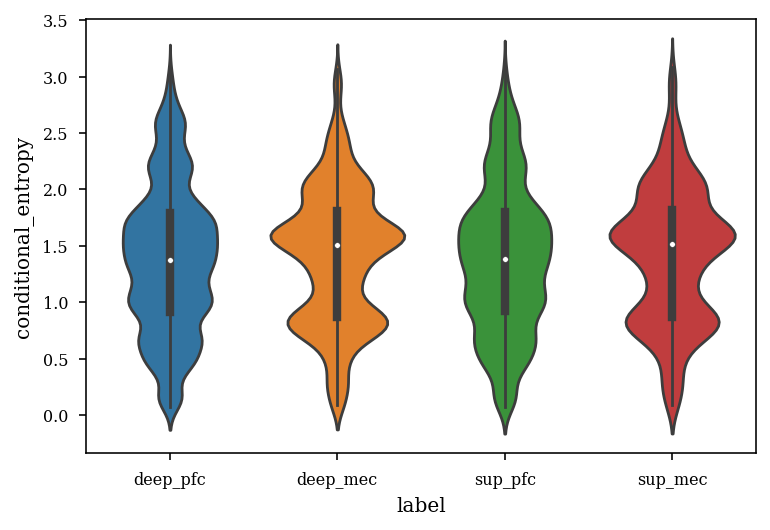

<AxesSubplot:xlabel='label', ylabel='mutual_info'>

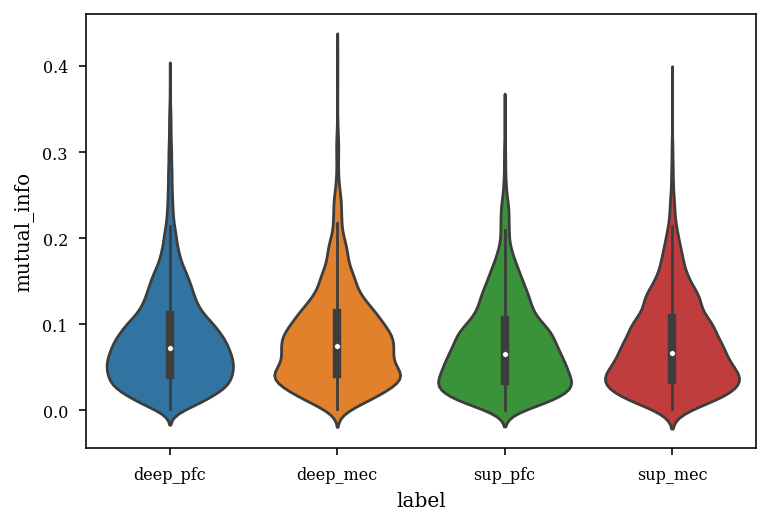

In [116]:
sns.violinplot(x="label", y="conditional_entropy", data=test_df)
plt.show()
sns.violinplot(x="label", y="mutual_info", data=test_df)


<AxesSubplot:xlabel='label', ylabel='conditional_entropy'>

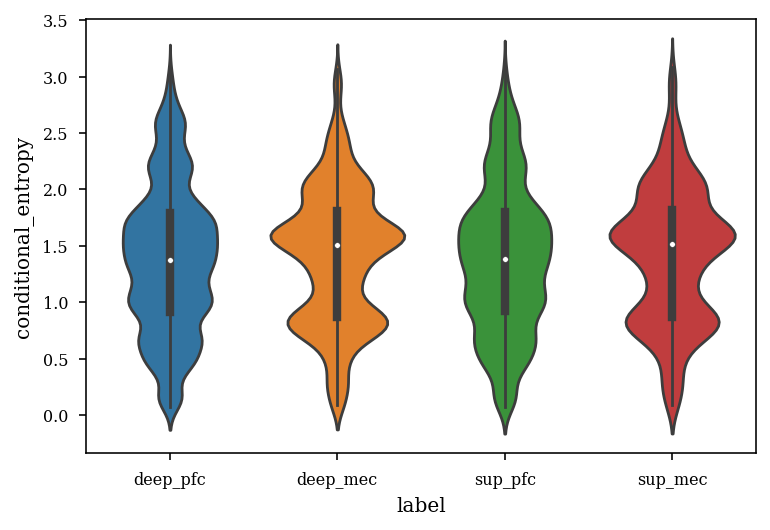

In [54]:
sns.violinplot(x="label", y="conditional_entropy", data=df)

In [38]:
deep_pfc = idx = (
    np.in1d(pairs[:, 0], np.where(cm.brainRegion.str.contains("CA1") & cm.deepSuperficial.str.contains("Deep"))[0])
    & np.in1d(pairs[:, 1], np.where(cm.brainRegion.str.contains("PFC"))[0])
) | (
    np.in1d(pairs[:, 0], np.where(cm.brainRegion.str.contains("PFC"))[0])
    & np.in1d(pairs[:, 1], np.where(cm.brainRegion.str.contains("CA1") & cm.deepSuperficial.str.contains("Deep"))[0])
)

deep_mec = idx = (
    np.in1d(pairs[:, 0], np.where(cm.brainRegion.str.contains("CA1") & cm.deepSuperficial.str.contains("Deep"))[0])
    & np.in1d(pairs[:, 1], np.where(cm.brainRegion.str.contains("MEC"))[0])
) | (
    np.in1d(pairs[:, 0], np.where(cm.brainRegion.str.contains("MEC"))[0])
    & np.in1d(pairs[:, 1], np.where(cm.brainRegion.str.contains("CA1") & cm.deepSuperficial.str.contains("Deep"))[0])
)

sup_pfc = idx = (
    np.in1d(pairs[:, 0], np.where(cm.brainRegion.str.contains("CA1") & cm.deepSuperficial.str.contains("Superficial"))[0])
    & np.in1d(pairs[:, 1], np.where(cm.brainRegion.str.contains("PFC"))[0])
) | (
    np.in1d(pairs[:, 0], np.where(cm.brainRegion.str.contains("PFC"))[0])
    & np.in1d(pairs[:, 1], np.where(cm.brainRegion.str.contains("CA1") & cm.deepSuperficial.str.contains("Superficial"))[0])
)

sup_mec = idx = (
    np.in1d(pairs[:, 0], np.where(cm.brainRegion.str.contains("CA1") & cm.deepSuperficial.str.contains("Superficial"))[0])
    & np.in1d(pairs[:, 1], np.where(cm.brainRegion.str.contains("MEC"))[0])
) | (
    np.in1d(pairs[:, 0], np.where(cm.brainRegion.str.contains("MEC"))[0])
    & np.in1d(pairs[:, 1], np.where(cm.brainRegion.str.contains("CA1") & cm.deepSuperficial.str.contains("Superficial"))[0])
)

In [12]:
df = pd.DataFrame()
df["mutual_info"] = np.hstack([mi[deep_pfc], mi[deep_mec], mi[sup_pfc], mi[sup_mec]])
df["conditional_entropy"] = np.hstack([ce[deep_pfc], ce[deep_mec], ce[sup_pfc], ce[sup_mec]])
df["label"] = np.hstack(
    [
        ["deep_pfc"] * len(mi[deep_pfc]),
        ["deep_mec"] * len(mi[deep_mec]),
        ["sup_pfc"] * len(mi[sup_pfc]),
        ["sup_mec"] * len(mi[sup_mec]),
    ]
)
df["reference"] = np.hstack(
    [
        cm.brainRegion.iloc[pairs[deep_pfc, 0]],
        cm.brainRegion.iloc[pairs[deep_mec, 0]],
        cm.brainRegion.iloc[pairs[sup_pfc, 0]],
        cm.brainRegion.iloc[pairs[sup_mec, 0]],
    ]
)

df["target"] = np.hstack(
    [
        cm.brainRegion.iloc[pairs[deep_pfc, 1]],
        cm.brainRegion.iloc[pairs[deep_mec, 1]],
        cm.brainRegion.iloc[pairs[sup_pfc, 1]],
        cm.brainRegion.iloc[pairs[sup_mec, 1]],
    ]
)

df["reference_uid"] = np.hstack(
    [
        cm.UID.iloc[pairs[deep_pfc, 0]],
        cm.UID.iloc[pairs[deep_mec, 0]],
        cm.UID.iloc[pairs[sup_pfc, 0]],
        cm.UID.iloc[pairs[sup_mec, 0]],
    ]
)

df["target_uid"] = np.hstack(
    [
        cm.UID.iloc[pairs[deep_pfc, 1]],
        cm.UID.iloc[pairs[deep_mec, 1]],
        cm.UID.iloc[pairs[sup_pfc, 1]],
        cm.UID.iloc[pairs[sup_mec, 1]],
    ]
)
df


,mutual_info,conditional_entropy,label,reference,target,reference_uid,target_uid
0,0.067176,1.429065,deep_pfc,PFC,CA1so,1,272
1,0.078890,1.717974,deep_pfc,PFC,CA1so,1,274
2,0.084916,1.647071,deep_pfc,PFC,CA1so,1,279
3,0.043270,1.159592,deep_pfc,PFC,CA1so,1,281
4,0.056667,1.454070,deep_pfc,PFC,CA1so,1,283
...,...,...,...,...,...,...,...
23953,0.026522,0.310773,sup_mec,CA1sr,MEC,420,540
23954,0.070829,0.800484,sup_mec,CA1sr,MEC,420,541
23955,0.057868,0.641952,sup_mec,CA1sr,MEC,420,542
23956,0.209924,1.954237,sup_mec,CA1sr,MEC,420,546


In [18]:
df.loc[~df.reference.str.contains("CA1"),"conditional_entropy"] = np.nan

<AxesSubplot:xlabel='mutual_info', ylabel='conditional_entropy'>

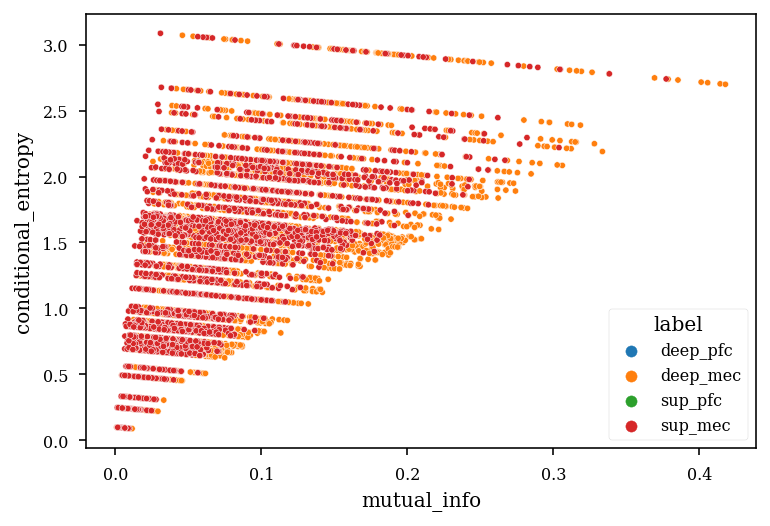

In [19]:
sns.scatterplot(x="mutual_info", y="conditional_entropy", hue="label", data=df,s=10)

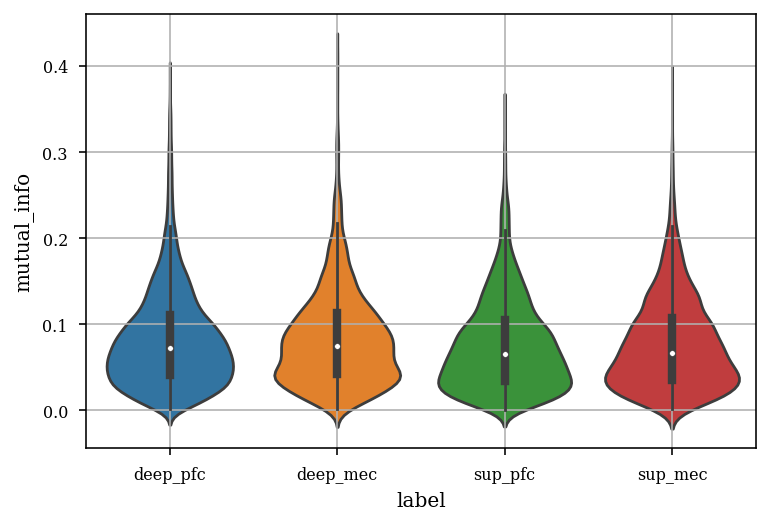

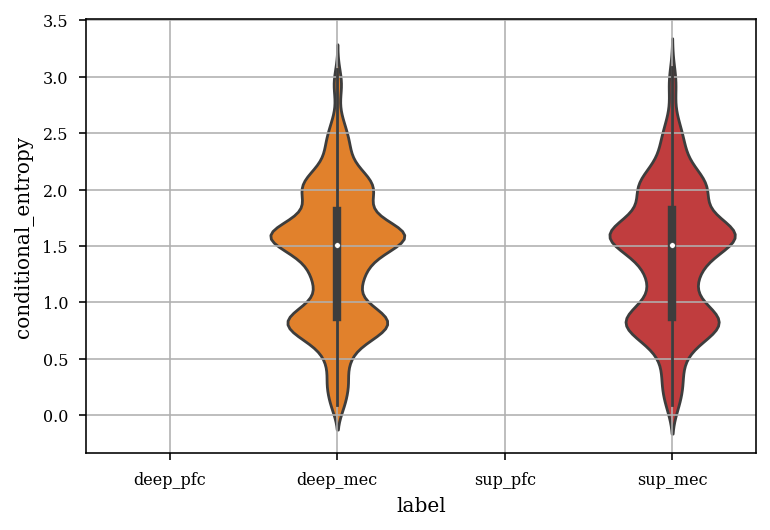

In [20]:
sns.violinplot(x="label", y="mutual_info", data=df)
# sns.stripplot(x="label", y="mi", data=df, color="black", size=1)
# plt.yscale("log")
plt.grid()
plt.show()

sns.violinplot(x="label", y="conditional_entropy", data=df)

plt.grid()
plt.show()